<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Logo 1" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="Logo 2" width="200" style="margin-left: 20px;"/>
</p>

# Data Challenge : Leukemia Risk Prediction


*GOAL OF THE CHALLENGE and WHY IT IS IMPORTANT:*

The goal of the challenge is to **predict disease risk for patients with blood cancer**, in the context of specific subtypes of adult myeloid leukemias.

The risk is measured through the **overall survival** of patients, i.e. the duration of survival from the diagnosis of the blood cancer to the time of death or last follow-up.

Estimating the prognosis of patients is critical for an optimal clinical management. 
For exemple, patients with low risk-disease will be offered supportive care to improve blood counts and quality of life, while patients with high-risk disease will be considered for hematopoietic stem cell transplantion.

The performance metric used in the challenge is the **IPCW-C-Index**.

*THE DATASETS*

The **training set is made of 3,323 patients**.

The **test set is made of 1,193 patients**.

For each patient, you have acces to CLINICAL data and MOLECULAR data.

The details of the data are as follows:

- OUTCOME:
  * OS_YEARS = Overall survival time in years
  * OS_STATUS = 1 (death) , 0 (alive at the last follow-up)

- CLINICAL DATA, with one line per patient:
  
  * ID = unique identifier per patient
  * CENTER = clinical center
  * BM_BLAST = Bone marrow blasts in % (blasts are abnormal blood cells)
  * WBC = White Blood Cell count in Giga/L 
  * ANC = Absolute Neutrophil count in Giga/L
  * MONOCYTES = Monocyte count in Giga/L
  * HB = Hemoglobin in g/dL
  * PLT = Platelets coutn in Giga/L
  * CYTOGENETICS = A description of the karyotype observed in the blood cells of the patients, measured by a cytogeneticist. Cytogenetics is the science of chromosomes. A karyotype is performed from the blood tumoral cells. The convention for notation is ISCN (https://en.wikipedia.org/wiki/International_System_for_Human_Cytogenomic_Nomenclature). Cytogenetic notation are: https://en.wikipedia.org/wiki/Cytogenetic_notation. Note that a karyotype can be normal or abnornal. The notation 46,XX denotes a normal karyotype in females (23 pairs of chromosomes including 2 chromosomes X) and 46,XY in males (23 pairs of chromosomes inclusing 1 chromosme X and 1 chromsome Y). A common abnormality in the blood cancerous cells might be for exemple a loss of chromosome 7 (monosomy 7, or -7), which is typically asssociated with higher risk disease

- GENE MOLECULAR DATA, with one line per patient per somatic mutation. Mutations are detected from the sequencing of the blood tumoral cells. 
We call somatic (= acquired) mutations the mutations that are found in the tumoral cells but not in other cells of the body.

  * ID = unique identifier per patient
  * CHR START END = position of the mutation on the human genome
  * REF ALT = reference and alternate (=mutant) nucleotide
  * GENE = the affected gene
  * PROTEIN_CHANGE = the consequence of the mutation on the protei that is expressed by a given gene
  * EFFECT = a broad categorization of the mutation consequences on a given gene.
  * VAF = Variant Allele Fraction = it represents the **proportion** of cells with the deleterious mutations. 

In [156]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Clinical Data
df = pd.read_csv("./clinical_train.csv")
df_eval = pd.read_csv("./clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("./molecular_train.csv")
maf_eval = pd.read_csv("./molecular_test.csv")

target_df = pd.read_csv("./target_train.csv")
#target_df_test = pd.read_csv("./target_test.csv")

# Preview the data
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [157]:
df_eval

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]"
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de..."
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8"
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r..."
...,...,...,...,...,...,...,...,...,...
1188,KYW1189,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1189,KYW1190,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190,KYW1191,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1191,KYW1192,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
maf_df

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0
...,...,...,...,...,...,...,...,...,...,...,...
10930,P131472,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10931,P131505,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10932,P131816,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10933,P132717,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN


In [159]:
target_df

,ID,OS_YEARS,OS_STATUS
0,P132697,1.115068,1.0
1,P132698,4.928767,0.0
2,P116889,2.043836,0.0
3,P132699,2.476712,1.0
4,P132700,3.145205,0.0
...,...,...,...
3318,P121828,NaN,NaN
3319,P121829,NaN,NaN
3320,P121830,1.997260,0.0
3321,P121853,0.095890,1.0


In [160]:

GENES_MAJEURS = ["TP53", "NPM1", "FLT3", "DNMT3A", "RUNX1", "ASXL1"]

# ----- TRAIN -----

maf_sel = maf_df[maf_df["GENE"].isin(GENES_MAJEURS)].copy()

gene_bin = (
    maf_sel
    .groupby(["ID", "GENE"])
    .size()
    .unstack(fill_value=0)
)

gene_bin = (gene_bin > 0).astype(int)
gene_bin.columns = [f"{c}_mut" for c in gene_bin.columns]

vaf_agg = maf_df.groupby("ID")["VAF"].agg(
    VAF_max="max",
    VAF_mean="mean"
)

nmut = maf_df.groupby("ID").size().rename("Nmut")

mut_features = (
    gene_bin
    .merge(vaf_agg, left_index=True, right_index=True, how="outer")
    .merge(nmut, left_index=True, right_index=True, how="outer")
    .fillna(0)
)

df_full = df.merge(mut_features, left_on="ID", right_index=True, how="left")
df_full[mut_features.columns] = df_full[mut_features.columns].fillna(0)

# ----- TEST -----

maf_sel_eval = maf_eval[maf_eval["GENE"].isin(GENES_MAJEURS)].copy()

gene_bin_eval = (
    maf_sel_eval
    .groupby(["ID", "GENE"])
    .size()
    .unstack(fill_value=0)
)

gene_bin_eval = (gene_bin_eval > 0).astype(int)
gene_bin_eval.columns = [f"{c}_mut" for c in gene_bin_eval.columns]

vaf_agg_eval = maf_eval.groupby("ID")["VAF"].agg(
    VAF_max="max",
    VAF_mean="mean"
)

nmut_eval = maf_eval.groupby("ID").size().rename("Nmut")

mut_features_eval = (
    gene_bin_eval
    .merge(vaf_agg_eval, left_index=True, right_index=True, how="outer")
    .merge(nmut_eval, left_index=True, right_index=True, how="outer")
    .fillna(0)
)

df_eval_full = df_eval.merge(mut_features_eval, left_on="ID", right_index=True, how="left")
df_eval_full[mut_features_eval.columns] = df_eval_full[mut_features_eval.columns].fillna(0)


# =========================================
# 3. INTERACTIONS CLÉS
# =========================================

df_full["TP53_x_BLAST"] = df_full.get("TP53_mut", 0) * df_full["BM_BLAST"]
df_full["Nmut_x_BLAST"] = df_full["Nmut"] * df_full["BM_BLAST"]
df_full["VAFmax_x_BLAST"] = df_full["VAF_max"] * df_full["BM_BLAST"]

df_eval_full["TP53_x_BLAST"] = df_eval_full.get("TP53_mut", 0) * df_eval_full["BM_BLAST"]
df_eval_full["Nmut_x_BLAST"] = df_eval_full["Nmut"] * df_eval_full["BM_BLAST"]
df_eval_full["VAFmax_x_BLAST"] = df_eval_full["VAF_max"] * df_eval_full["BM_BLAST"]

cyto = df_full["CYTOGENETICS"].fillna("").str.lower()

df_full["CYTO_NORMAL"] = cyto.str.contains("46,xx|46,xy").astype(int)
df_full["CYTO_COMPLEX"] = (cyto.str.count("del|inv|t\\(|\\-") >= 3).astype(int)

df_full["CYTO_DEL5Q"]  = cyto.str.contains("del\\(5q\\)").astype(int)
df_full["CYTO_MINUS7"] = cyto.str.contains("\\-7").astype(int)

df_full["CYTO_MONOSOMAL"] = (
    df_full["CYTO_DEL5Q"] | df_full["CYTO_MINUS7"]
).astype(int)

df_full["CYTO_INV16"] = cyto.str.contains("inv\\(16\\)").astype(int)
df_full["CYTO_T821"]  = cyto.str.contains("t\\(8;21\\)").astype(int)

df_full["CYTO_HIGH_RISK"] = (
    df_full["CYTO_COMPLEX"] | df_full["CYTO_MONOSOMAL"]
).astype(int)


cyto_eval = df_eval_full["CYTOGENETICS"].fillna("").str.lower()

df_eval_full["CYTO_NORMAL"] = cyto_eval.str.contains("46,xx|46,xy").astype(int)
df_eval_full["CYTO_COMPLEX"] = (cyto_eval.str.count("del|inv|t\\(|\\-") >= 3).astype(int)

df_eval_full["CYTO_DEL5Q"]  = cyto_eval.str.contains("del\\(5q\\)").astype(int)
df_eval_full["CYTO_MINUS7"] = cyto_eval.str.contains("\\-7").astype(int)

df_eval_full["CYTO_MONOSOMAL"] = (
    df_eval_full["CYTO_DEL5Q"] | df_eval_full["CYTO_MINUS7"]
).astype(int)

df_eval_full["CYTO_INV16"] = cyto_eval.str.contains("inv\\(16\\)").astype(int)
df_eval_full["CYTO_T821"]  = cyto_eval.str.contains("t\\(8;21\\)").astype(int)

df_eval_full["CYTO_HIGH_RISK"] = (
    df_eval_full["CYTO_COMPLEX"] | df_eval_full["CYTO_MONOSOMAL"]
).astype(int)


df_full["HB_LOW"] = (df_full["HB"] < 10).astype(int)
df_full["PLT_LOW"] = (df_full["PLT"] < 50).astype(int)
df_full["WBC_HIGH"] = (df_full["WBC"] > 50).astype(int)
df_full["BLAST_HIGH"] = (df_full["BM_BLAST"] > 50).astype(int)

df_eval_full["HB_LOW"] = (df_eval_full["HB"] < 10).astype(int)
df_eval_full["PLT_LOW"] = (df_eval_full["PLT"] < 50).astype(int)
df_eval_full["WBC_HIGH"] = (df_eval_full["WBC"] > 50).astype(int)
df_eval_full["BLAST_HIGH"] = (df_eval_full["BM_BLAST"] > 50).astype(int)

maf_df["IS_FRAMESHIFT"] = maf_df["EFFECT"].str.contains("frameshift", case=False, na=False).astype(int)
maf_df["IS_NONSENSE"]   = maf_df["EFFECT"].str.contains("nonsense|stop", case=False, na=False).astype(int)
maf_df["IS_MISSENSE"]   = maf_df["EFFECT"].str.contains("missense", case=False, na=False).astype(int)

impact_agg = maf_df.groupby("ID")[["IS_FRAMESHIFT", "IS_NONSENSE", "IS_MISSENSE"]].sum()

df_full = df_full.merge(impact_agg, on="ID", how="left").fillna(0)
maf_eval["IS_FRAMESHIFT"] = maf_eval["EFFECT"].str.contains("frameshift", case=False, na=False).astype(int)
maf_eval["IS_NONSENSE"]   = maf_eval["EFFECT"].str.contains("nonsense|stop", case=False, na=False).astype(int)
maf_eval["IS_MISSENSE"]   = maf_eval["EFFECT"].str.contains("missense", case=False, na=False).astype(int)

impact_agg_eval = maf_eval.groupby("ID")[["IS_FRAMESHIFT", "IS_NONSENSE", "IS_MISSENSE"]].sum()

df_eval_full = df_eval_full.merge(
    impact_agg_eval, on="ID", how="left"
).fillna(0)

# =========================================
# 4. FEATURES FINALES
# =========================================

FEATURES_FINAL = [
 'BM_BLAST','HB','PLT','Nmut','VAF_max','VAF_mean',
 'TP53_mut','NPM1_mut','FLT3_mut','DNMT3A_mut','RUNX1_mut','ASXL1_mut',
 'TP53_x_BLAST','Nmut_x_BLAST','VAFmax_x_BLAST',
 'CYTO_NORMAL','CYTO_COMPLEX','CYTO_MONOSOMAL','CYTO_HIGH_RISK',
 'CYTO_INV16','CYTO_T821',
 'HB_LOW','PLT_LOW','WBC_HIGH','BLAST_HIGH',
 'IS_FRAMESHIFT','IS_NONSENSE','IS_MISSENSE'
]



### Step 1: Data Preparation (clinical data only)

For survival analysis, we’ll format the dataset so that OS_YEARS represents the time variable and OS_STATUS represents the event indicator.

In [161]:
FEATURES_FINAL

['BM_BLAST',
 'HB',
 'PLT',
 'Nmut',
 'VAF_max',
 'VAF_mean',
 'TP53_mut',
 'NPM1_mut',
 'FLT3_mut',
 'DNMT3A_mut',
 'RUNX1_mut',
 'ASXL1_mut',
 'TP53_x_BLAST',
 'Nmut_x_BLAST',
 'VAFmax_x_BLAST',
 'CYTO_NORMAL',
 'CYTO_COMPLEX',
 'CYTO_MONOSOMAL',
 'CYTO_HIGH_RISK',
 'CYTO_INV16',
 'CYTO_T821',
 'HB_LOW',
 'PLT_LOW',
 'WBC_HIGH',
 'BLAST_HIGH',
 'IS_FRAMESHIFT',
 'IS_NONSENSE',
 'IS_MISSENSE']

In [162]:
X = df_model[FEATURES_FINAL]
X

KeyError: "['CYTO_NORMAL', 'CYTO_COMPLEX', 'CYTO_MONOSOMAL', 'CYTO_HIGH_RISK', 'CYTO_INV16', 'CYTO_T821', 'HB_LOW', 'PLT_LOW', 'WBC_HIGH', 'BLAST_HIGH', 'IS_FRAMESHIFT', 'IS_NONSENSE', 'IS_MISSENSE'] not in index"

In [163]:
# =========================================
# 5. NETTOYAGE TARGET + ALIGNEMENT FINAL
# =========================================

# Nettoyage target
target_df = target_df.dropna(subset=["OS_YEARS", "OS_STATUS"]).copy()
target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)
target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")

# Merge FINAL (UNE SEULE SOURCE POUR X ET y)
df_model = df_full.merge(
    target_df[["ID", "OS_YEARS", "OS_STATUS"]],
    on="ID",
    how="inner"
)

# Vérification
print("df_full shape  :", df_full.shape)
print("df_model shape :", df_model.shape)

# MATRICES FINALES (UNE SEULE LIGNE DE VÉRITÉ)
X = df_model[FEATURES_FINAL]
y = Surv.from_dataframe("OS_STATUS", "OS_YEARS", df_model)

print("✅ X shape :", X.shape)
print("✅ y shape :", y.shape)


df_full shape  : (3323, 36)
df_model shape : (3173, 38)
✅ X shape : (3173, 28)
✅ y shape : (3173,)


In [164]:
X

,BM_BLAST,HB,PLT,Nmut,VAF_max,VAF_mean,TP53_mut,NPM1_mut,FLT3_mut,DNMT3A_mut,...,CYTO_HIGH_RISK,CYTO_INV16,CYTO_T821,HB_LOW,PLT_LOW,WBC_HIGH,BLAST_HIGH,IS_FRAMESHIFT,IS_NONSENSE,IS_MISSENSE
0,14.0,7.6,119.0,9.0,0.4220,0.251578,0.0,0.0,1.0,1.0,...,0,0,0,1,0,0,0,3.0,1.0,0.0
1,1.0,11.6,42.0,3.0,0.2825,0.272867,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,2.0,1.0,0.0
2,15.0,14.2,81.0,3.0,0.0480,0.039333,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,2.0,0.0
3,1.0,8.9,77.0,11.0,0.4770,0.209227,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1.0,0.0,0.0
4,6.0,11.1,195.0,1.0,0.4721,0.472100,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,1.0,10.2,78.0,4.0,0.5010,0.169000,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
3169,1.5,11.3,40.0,2.0,0.8190,0.427500,1.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0.0,0.0,0.0
3170,0.0,9.4,86.0,6.0,0.4390,0.244650,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,1.0,2.0,0.0
3171,5.0,11.4,102.0,4.0,0.2690,0.184250,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


In [165]:
y

array([( True, 1.11506849), (False, 4.92876712), (False, 2.04383562), ...,
       (False, 1.99726027), ( True, 0.09589041), (False, 2.29041096)],
      shape=(3173,), dtype=[('OS_STATUS', '?'), ('OS_YEARS', '<f8')])

### Step 2: Splitting the Dataset
We’ll split the data into training and testing sets to evaluate the model’s performance.

In [166]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [167]:
X_train

,BM_BLAST,HB,PLT,Nmut,VAF_max,VAF_mean,TP53_mut,NPM1_mut,FLT3_mut,DNMT3A_mut,...,CYTO_HIGH_RISK,CYTO_INV16,CYTO_T821,HB_LOW,PLT_LOW,WBC_HIGH,BLAST_HIGH,IS_FRAMESHIFT,IS_NONSENSE,IS_MISSENSE
1018,3.0,9.1,150.0,5.0,0.6072,0.398940,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,3.0,0.0,0.0
1862,15.0,11.0,45.0,5.0,0.8717,0.441860,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1.0,1.0,0.0
195,6.0,6.9,132.0,2.0,0.4840,0.418000,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0.0,0.0,0.0
2008,2.0,10.0,178.0,4.0,0.4300,0.417500,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,0,0.0,0.0,0.0
2023,10.0,10.0,53.0,1.0,0.1080,0.108000,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,3.0,7.4,82.0,3.0,0.1880,0.162067,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1.0,0.0,0.0
1095,7.0,9.9,234.0,1.0,0.0900,0.090000,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0.0,0.0,0.0
1130,0.0,10.9,174.0,3.0,0.5480,0.259000,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1294,0.0,10.7,187.0,3.0,0.4872,0.431467,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2.0,0.0,0.0


In [168]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X.columns,
    index=X_train.index,
)

X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X.columns,
    index=X_test.index,
)

In [169]:
X_train.shape

(2221, 28)

### Step 3: Training Standard Machine Learning Methods

In this step, we train a standard LightGBM model on survival data, but we do not account for censoring. Instead of treating the event status, we use only the observed survival times as the target variable. This approach disregards whether an individual’s event (e.g., death) was observed or censored, effectively treating the problem as a standard regression task. While this method provides a basic benchmark, it may be less accurate than survival-specific models (but still be explored!), as it does not leverage the information contained in censored observations.

In [170]:
# ================================
# LIGHTGBM AVEC POIDS DE CENSURE
# ================================

# IPCW à l'entraînement (approximation simple)
event = y_train["OS_STATUS"].astype(int)
time  = y_train["OS_YEARS"]

# Poids simples : morts = 1, censurés = 0.3 (proxy brutal)
weights = np.where(event == 1, 1.0, 0.3)

train_dataset = lgb.Dataset(
    X_train,
    label=time,
    weight=weights
)

params = {
    "objective": "regression",
    "max_depth": 3,
    "learning_rate": 0.05,
    "verbose": -1
}

model = lgb.train(params, train_dataset)

pred_train = -model.predict(X_train)
pred_test  = -model.predict(X_test)

train_ci = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci  = concordance_index_ipcw(y_train, y_test,  pred_test,  tau=7)[0]

print(f"✅ LightGBM proxy-survival TRAIN : {train_ci:.3f}")
print(f"✅ LightGBM proxy-survival TEST  : {test_ci:.3f}")


✅ LightGBM proxy-survival TRAIN : 0.728
✅ LightGBM proxy-survival TEST  : 0.697


<Figure size 2000x1000 with 0 Axes>

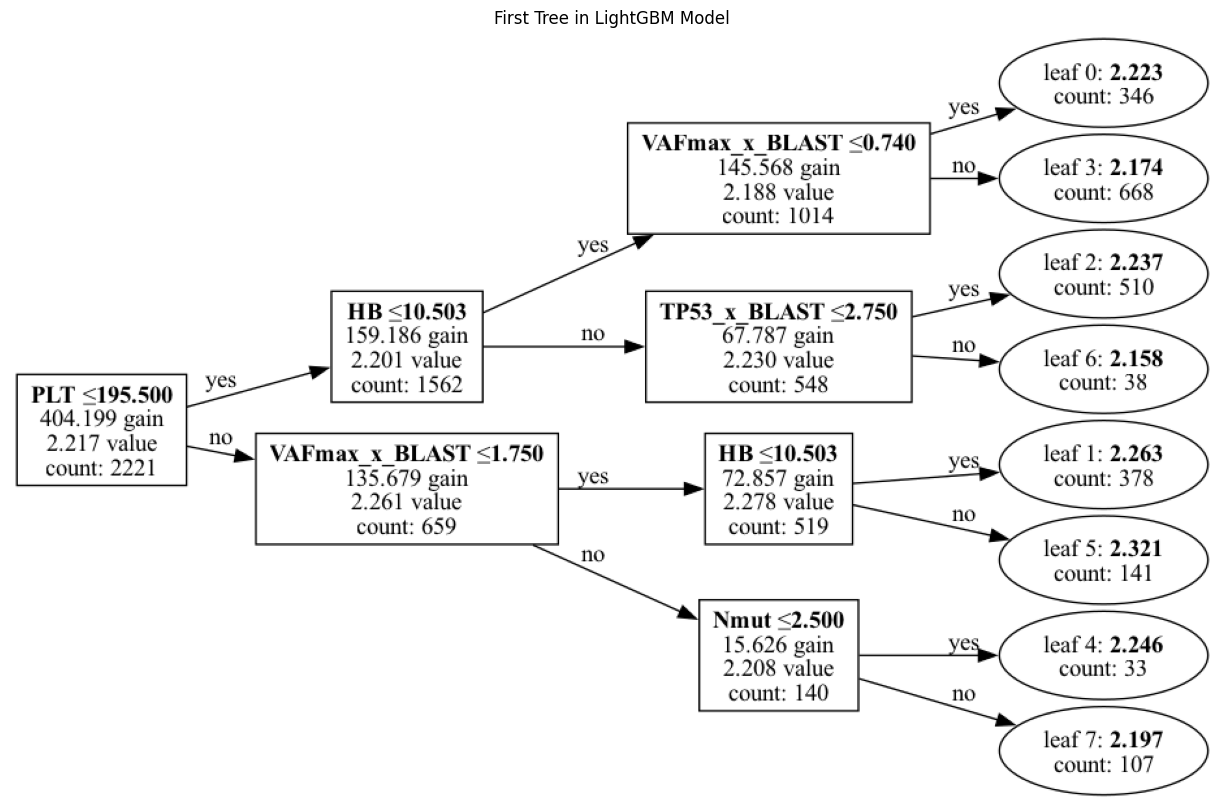

In [171]:
# Assuming the LightGBM model is defined as `model`
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.title("First Tree in LightGBM Model")
plt.show()

### Step 4: Cox Proportional Hazards Model

To account for censoring in survival analysis, we use a Cox Proportional Hazards (Cox PH) model, a widely used method that estimates the effect of covariates on survival times without assuming a specific baseline survival distribution. The Cox PH model is based on the hazard function, $h(t | X)$, which represents the instantaneous risk of an event (e.g., death) at time $t$ given covariates $X$. The model assumes that the hazard can be expressed as:

$$h(t | X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)$$


where $h_0(t)$ is the baseline hazard function, and $\beta$ values are coefficients for each covariate, representing the effect of $X$ on the hazard. Importantly, the proportional hazards assumption implies that the hazard ratios between individuals are constant over time. This approach effectively leverages both observed and censored survival times, making it a more suitable method for survival data compared to standard regression techniques that ignore censoring.


In [173]:
X_train

,BM_BLAST,HB,PLT,Nmut,VAF_max,VAF_mean,TP53_mut,NPM1_mut,FLT3_mut,DNMT3A_mut,...,CYTO_HIGH_RISK,CYTO_INV16,CYTO_T821,HB_LOW,PLT_LOW,WBC_HIGH,BLAST_HIGH,IS_FRAMESHIFT,IS_NONSENSE,IS_MISSENSE
1018,3.0,9.1,150.0,5.0,0.6072,0.398940,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0
1862,15.0,11.0,45.0,5.0,0.8717,0.441860,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
195,6.0,6.9,132.0,2.0,0.4840,0.418000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2008,2.0,10.0,178.0,4.0,0.4300,0.417500,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023,10.0,10.0,53.0,1.0,0.1080,0.108000,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,3.0,7.4,82.0,3.0,0.1880,0.162067,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1095,7.0,9.9,234.0,1.0,0.0900,0.090000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1130,0.0,10.9,174.0,3.0,0.5480,0.259000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,0.0,10.7,187.0,3.0,0.4872,0.431467,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [176]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis(alpha=1e-2)
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.71
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.70


In [177]:
coef = pd.Series(cox.coef_, index=X_train.columns).sort_values()
print(coef)

BLAST_HIGH       -1.320435
CYTO_NORMAL      -0.175854
IS_NONSENSE      -0.094982
IS_FRAMESHIFT    -0.072069
HB               -0.048434
VAFmax_x_BLAST   -0.012074
Nmut_x_BLAST     -0.004655
PLT              -0.001167
CYTO_T821         0.000000
CYTO_INV16        0.000000
IS_MISSENSE       0.000000
TP53_x_BLAST      0.007824
NPM1_mut          0.017798
CYTO_HIGH_RISK    0.038072
BM_BLAST          0.047148
Nmut              0.142685
PLT_LOW           0.229363
DNMT3A_mut        0.233822
CYTO_MONOSOMAL    0.275878
ASXL1_mut         0.361262
HB_LOW            0.372561
FLT3_mut          0.396173
RUNX1_mut         0.432658
VAF_mean          0.494987
VAF_max           0.514192
TP53_mut          0.609750
CYTO_COMPLEX      0.628947
WBC_HIGH          0.857579
dtype: float64


### Step 5: Naive Approach to Incorporate Mutations

In this step, we take a very naive approach to account for genetic mutations by simply counting the total number of somatic mutations per patient. Instead of analyzing specific mutations or their biological impact, we use this aggregate count as a basic feature to reflect the mutational burden for each individual. Although simplistic, this feature can serve as a general indicator of genetic variability across patients, which may influence survival outcomes. More sophisticated mutation analysis could be incorporated in future models to improve predictive power.


In [178]:

features = FEATURES_FINAL # si Nmut n’est pas déjà dans FEATURES_FINAL

X = df_model[features]
y = Surv.from_dataframe("OS_STATUS", "OS_YEARS", df_model)

print("✅ X shape :", X.shape)
print("✅ y shape :", y.shape)

✅ X shape : (3173, 28)
✅ y shape : (3173,)


In [179]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [180]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features]= imputer.transform(X_test[features])

In [182]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis(1e-2)
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.71
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.70


### Inference on test set

In [184]:
# 1) On récupère les colonnes dans le bon ordre
X_eval = df_eval_full[FEATURES_FINAL]


X_eval = pd.DataFrame(
    imputer.transform(X_eval.to_numpy()),   # ✅ on passe en numpy pour éviter tout bug de noms
    columns=X_train.columns,
    index=df_eval_full.index,
)

# 4) Prédiction Cox
prediction_on_test_set = cox.predict(X_eval)


/opt/anaconda3/envs/survival/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [185]:
submission = pd.Series(prediction_on_test_set, index=df_eval['ID'], name='OS_YEARS')

In [188]:
submission = submission.rename("risk_score")


In [189]:

submission.to_csv('./benchmark_submission_v2.csv')

In [ ]:
submission

In [ ]:
random_submission = pd.Series(np.random.uniform(0, 1, len(submission)),index =submission.index, name='OS_YEARS')


In [ ]:
random_submission.to_csv('./random_submission.csv')

In [ ]:
random_submission